# Modelling lithium plating on composite electrodes in PyBaMM

This notebook shows how PyBaMM [8] can be used to model both reversible and irreversible lithium plating on composite electrodes.

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import numpy as np

import pybamm

Note: you may need to restart the kernel to use updated packages.


The Doyle-Fuller-Newman model [3] is upgraded with three different lithium plating models. Model 1 contains the reversible lithium plating model of O'Kane et al. [5]. Model 2 contains the same model but with the lithium stripping capability removed, making the plating irreversible. Model 3 contains the updated partially reversible plating of O'Kane et al. [6]. The parameters are taken from Chen et al.'s investigation [2] of an LG M50 cell.

In [2]:
# Defining the composite model
model = pybamm.lithium_ion.DFN(
    {
        "particle phases": ("2", "1"),
        "open-circuit potential": (("single", "current sigmoid"), "single"),
    }
)
# Invoking the Chen2020 parameter set
parameter_values = pybamm.ParameterValues("Chen2020_composite")

In [3]:
# Definig temperature/concentration dependent parameters for plating
def graphite_plating_exchange_current_density_OKane2020(c_e, c_Li, T):
    """
    Exchange-current density for Li plating reaction [A.m-2].
    References
    ----------
    .. [1] O’Kane, Simon EJ, Ian D. Campbell, Mohamed WJ Marzook, Gregory J. Offer, and
    Monica Marinescu. "Physical origin of the differential voltage minimum associated
    with lithium plating in Li-ion batteries." Journal of The Electrochemical Society
    167, no. 9 (2020): 090540.
    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_Li : :class:`pybamm.Symbol`
        Plated lithium concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]
    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """

    k_plating = pybamm.Parameter(
        "Primary: Lithium plating kinetic rate constant [m.s-1]"
    )

    return pybamm.constants.F * k_plating * c_e


def graphite_stripping_exchange_current_density_OKane2020(c_e, c_Li, T):
    """
    Exchange-current density for Li stripping reaction [A.m-2].
    References
    ----------
    .. [1] O’Kane, Simon EJ, Ian D. Campbell, Mohamed WJ Marzook, Gregory J. Offer, and
    Monica Marinescu. "Physical origin of the differential voltage minimum associated
    with lithium plating in Li-ion batteries." Journal of The Electrochemical Society
    167, no. 9 (2020): 090540.
    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_Li : :class:`pybamm.Symbol`
        Plated lithium concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]
    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """

    k_plating = pybamm.Parameter(
        "Primary: Lithium plating kinetic rate constant [m.s-1]"
    )

    return pybamm.constants.F * k_plating * c_Li


def graphite_SEI_limited_dead_lithium_OKane2022(L_sei):
    """
    Decay rate for dead lithium formation [s-1].
    References
    ----------
    .. [1] Simon E. J. O'Kane, Weilong Ai, Ganesh Madabattula, Diega Alonso-Alvarez,
    Robert Timms, Valentin Sulzer, Jaqueline Sophie Edge, Billy Wu, Gregory J. Offer
    and Monica Marinescu. "Lithium-ion battery degradation: how to model it."
    Physical Chemistry: Chemical Physics 24, no. 13 (2022): 7909-7922.
    Parameters
    ----------
    L_sei : :class:`pybamm.Symbol`
        Total SEI thickness [m]
    Returns
    -------
    :class:`pybamm.Symbol`
        Dead lithium decay rate [s-1]
    """

    gamma_0 = pybamm.Parameter("Primary: Dead lithium decay constant [s-1]")
    L_inner_0 = pybamm.Parameter("Primary: Initial inner SEI thickness [m]")
    L_outer_0 = pybamm.Parameter("Primary: Initial outer SEI thickness [m]")
    L_sei_0 = L_inner_0 + L_outer_0

    gamma = gamma_0 * L_sei_0 / L_sei

    return gamma


def silicon_plating_exchange_current_density_OKane2020(c_e, c_Li, T):
    """
    Exchange-current density for Li plating reaction [A.m-2].
    References
    ----------
    .. [1] O’Kane, Simon EJ, Ian D. Campbell, Mohamed WJ Marzook, Gregory J. Offer, and
    Monica Marinescu. "Physical origin of the differential voltage minimum associated
    with lithium plating in Li-ion batteries." Journal of The Electrochemical Society
    167, no. 9 (2020): 090540.
    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_Li : :class:`pybamm.Symbol`
        Plated lithium concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]
    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """

    k_plating = pybamm.Parameter(
        "Secondary: Lithium plating kinetic rate constant [m.s-1]"
    )

    return pybamm.constants.F * k_plating * c_e


def silicon_stripping_exchange_current_density_OKane2020(c_e, c_Li, T):
    """
    Exchange-current density for Li stripping reaction [A.m-2].
    References
    ----------
    .. [1] O’Kane, Simon EJ, Ian D. Campbell, Mohamed WJ Marzook, Gregory J. Offer, and
    Monica Marinescu. "Physical origin of the differential voltage minimum associated
    with lithium plating in Li-ion batteries." Journal of The Electrochemical Society
    167, no. 9 (2020): 090540.
    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_Li : :class:`pybamm.Symbol`
        Plated lithium concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]
    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """

    k_plating = pybamm.Parameter(
        "Secondary: Lithium plating kinetic rate constant [m.s-1]"
    )

    return pybamm.constants.F * k_plating * c_Li


def silicon_SEI_limited_dead_lithium_OKane2022(L_sei):
    """
    Decay rate for dead lithium formation [s-1].
    References
    ----------
    .. [1] Simon E. J. O'Kane, Weilong Ai, Ganesh Madabattula, Diega Alonso-Alvarez,
    Robert Timms, Valentin Sulzer, Jaqueline Sophie Edge, Billy Wu, Gregory J. Offer
    and Monica Marinescu. "Lithium-ion battery degradation: how to model it."
    Physical Chemistry: Chemical Physics 24, no. 13 (2022): 7909-7922.
    Parameters
    ----------
    L_sei : :class:`pybamm.Symbol`
        Total SEI thickness [m]
    Returns
    -------
    :class:`pybamm.Symbol`
        Dead lithium decay rate [s-1]
    """

    gamma_0 = pybamm.Parameter("Secondary: Dead lithium decay constant [s-1]")
    L_inner_0 = pybamm.Parameter("Secondary: Initial inner SEI thickness [m]")
    L_outer_0 = pybamm.Parameter("Secondary: Initial outer SEI thickness [m]")
    L_sei_0 = L_inner_0 + L_outer_0

    gamma = gamma_0 * L_sei_0 / L_sei

    return gamma


def graphite_LGM50_electrolyte_exchange_current_density_Chen2020(
    c_e, c_s_surf, c_s_max, T
):
    """
    Exchange-current density for Butler-Volmer reactions between graphite and LiPF6 in
    EC:DMC.

    References
    ----------
    .. [1] Chang-Hui Chen, Ferran Brosa Planella, Kieran O’Regan, Dominika Gastol, W.
    Dhammika Widanage, and Emma Kendrick. "Development of Experimental Techniques for
    Parameterization of Multi-scale Lithium-ion Battery Models." Journal of the
    Electrochemical Society 167 (2020): 080534.

    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_s_surf : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]

    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """
    m_ref = 6.48e-7  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 35000
    arrhenius = np.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5

In [4]:
# Adding plating parameters to the parameter set
# plating_parameters =
parameter_values.update(
    {
        # Plating parameters referred from OKane2022
        "Lithium metal partial molar volume [m3.mol-1]": 1.3e-05,
        "Primary: Lithium plating kinetic rate constant [m.s-1]": 1e-09,
        "Primary: Exchange-current density for plating [A.m-2]"
        "": graphite_plating_exchange_current_density_OKane2020,
        "Primary: Exchange-current density for stripping [A.m-2]"
        "": graphite_stripping_exchange_current_density_OKane2020,
        "Primary: Initial plated lithium concentration [mol.m-3]": 0.0,
        "Primary: Typical plated lithium concentration [mol.m-3]": 1000.0,
        "Primary: Lithium plating transfer coefficient": 0.65,
        "Primary: Dead lithium decay constant [s-1]": 1e-06,
        "Primary: Dead lithium decay rate [s-1]"
        "": graphite_SEI_limited_dead_lithium_OKane2022,
        "Secondary: Lithium plating kinetic rate constant [m.s-1]": 1e-09,
        "Secondary: Exchange-current density for plating [A.m-2]"
        "": silicon_plating_exchange_current_density_OKane2020,
        "Secondary: Exchange-current density for stripping [A.m-2]"
        "": silicon_stripping_exchange_current_density_OKane2020,
        "Secondary: Initial plated lithium concentration [mol.m-3]": 0.0,
        "Secondary: Typical plated lithium concentration [mol.m-3]": 1000.0,
        "Secondary: Lithium plating transfer coefficient": 0.65,
        "Secondary: Dead lithium decay constant [s-1]": 1e-06,
        "Secondary: Dead lithium decay rate [s-1]"
        "": silicon_SEI_limited_dead_lithium_OKane2022,
    },
    check_already_exists=False,
)

In [5]:
# choose models
composite_options = {
    "particle phases": ("2", "1"),
    "open-circuit potential": (("single", "current sigmoid"), "single"),
}
plating_options = ["reversible", "irreversible", "partially reversible"]
models = {}
for option in plating_options:
    # Merge the plating option with the default options
    options = composite_options.copy()
    options["lithium plating"] = option

    # Initialize the DFN model with these options
    models[option] = pybamm.lithium_ion.DFN(options=options, name=option)

# pick parameters
parameter_values.update({"Ambient temperature [K]": 268.15})
parameter_values.update({"Upper voltage cut-off [V]": 4.21})
parameter_values.update(
    {"Lithium plating transfer coefficient": 0.5}, check_already_exists=False
)
parameter_values.update(
    {"Dead lithium decay constant [s-1]": 1e-4}, check_already_exists=False
)
parameter_values.update(
    {"Primary: Initial inner SEI thickness [m]": 5e-09}, check_already_exists=False
)
parameter_values.update(
    {"Primary: Initial outer SEI thickness [m]": 5e-09}, check_already_exists=False
)
parameter_values.update(
    {"Secondary: Initial inner SEI thickness [m]": 5e-09}, check_already_exists=False
)
parameter_values.update(
    {"Secondary: Initial outer SEI thickness [m]": 5e-09}, check_already_exists=False
)
# parameter_values.update({"Lithium plating kinetic rate constant [m.s-1]": 1E-9})

A series of simple fast charging experiments based on those of Ren et al. [7] is defined here. We first initialise the model at 0% SoC by performing a C/20 discharge (see more details on how to initialise a model from a simulation in [this notebook](../initialize-model-with-solution.ipynb)).

In [6]:
# specify experiments
pybamm.citations.register("Ren2018")

s = pybamm.step.string
experiment_discharge = pybamm.Experiment(
    [
        (
            "Discharge at C/20 until 2.5 V",
            "Rest for 1 hour",
        )
    ]
)

sims_discharge = []
for model in models.values():
    sim_discharge = pybamm.Simulation(
        model, parameter_values=parameter_values, experiment=experiment_discharge
    )
    sol_discharge = sim_discharge.solve(calc_esoh=False)
    model.set_initial_conditions_from(sol_discharge, inplace=True)
    sims_discharge.append(sim_discharge)

And we can now define the different experiments to charge at different C-rates.

In [7]:
C_rates = ["2C", "1C", "C/2", "C/4", "C/8"]
experiments = {}
for C_rate in C_rates:
    experiments[C_rate] = pybamm.Experiment(
        [
            (
                f"Charge at {C_rate} until 4.2 V",
                "Hold at 4.2 V until C/20",
                "Rest for 1 hour",
            )
        ]
    )

Solve the reversible plating model first.

In [8]:
def define_and_solve_sims(model, experiments, parameter_values):
    sims = {}
    for C_rate, experiment in experiments.items():
        sim = pybamm.Simulation(
            model, experiment=experiment, parameter_values=parameter_values
        )
        sim.solve(calc_esoh=False)
        sims[C_rate] = sim

    return sims


sims_reversible = define_and_solve_sims(
    models["reversible"], experiments, parameter_values
)

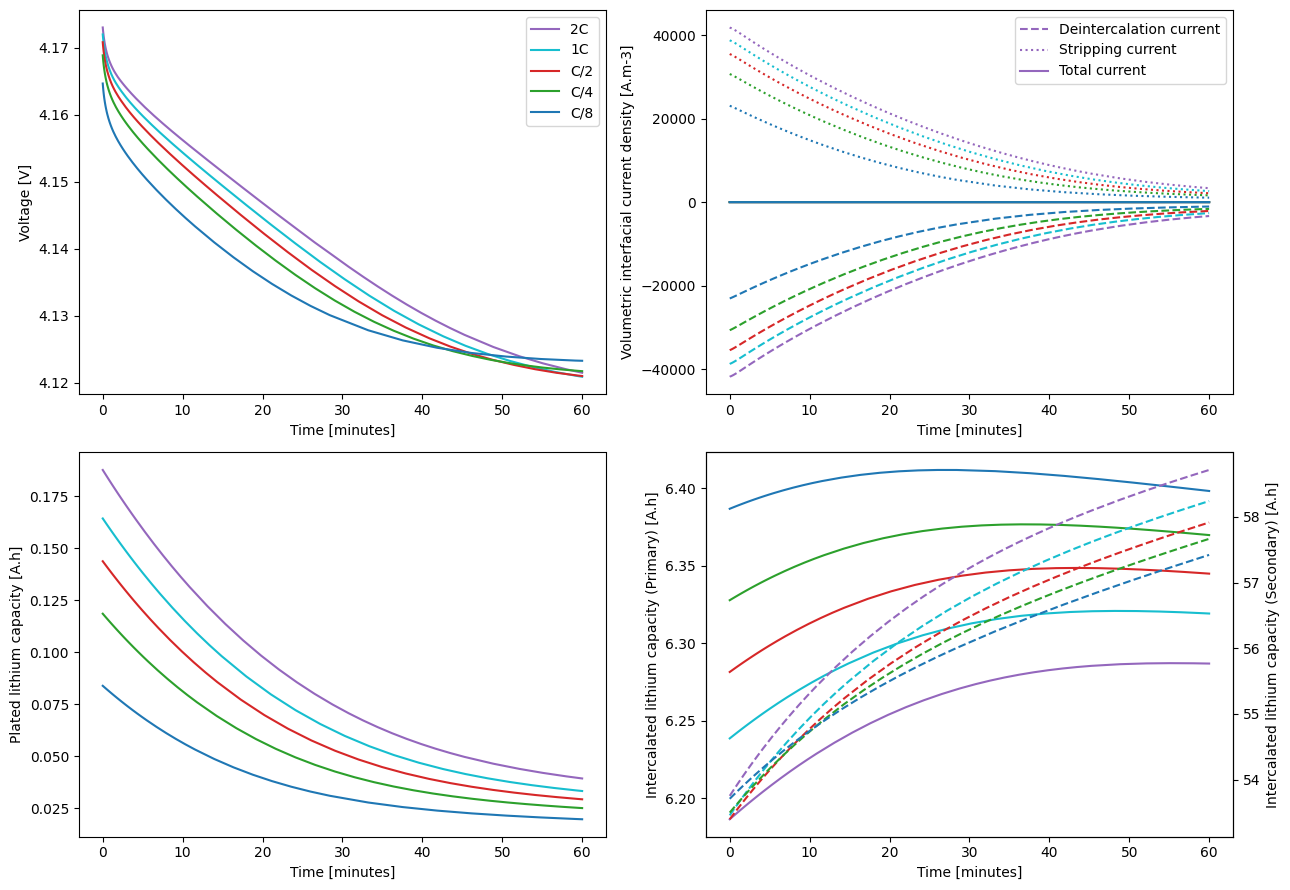

In [9]:
colors = ["tab:purple", "tab:cyan", "tab:red", "tab:green", "tab:blue"]
linestyles = ["dashed", "dotted", "solid"]

param = models["reversible"].param
A = parameter_values.evaluate(param.L_y * param.L_z)
F = parameter_values.evaluate(param.F)
L_n = parameter_values.evaluate(param.n.L)

currents = [
    "X-averaged negative electrode volumetric interfacial current density [A.m-3]",
    "X-averaged negative electrode lithium plating volumetric interfacial current density [A.m-3]",
    "Sum of x-averaged negative electrode volumetric interfacial current densities [A.m-3]",
]


def plot(sims):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(13, 9))
    ax2 = axs[1, 1].twinx()  # Create a secondary y-axis
    for (C_rate, sim), color in zip(sims.items(), colors, strict=False):
        # Isolate final equilibration phase
        sol = sim.solution.cycles[0].steps[2]

        # Voltage vs time
        t = sol["Time [min]"].entries
        t = t - t[0]
        V = sol["Voltage [V]"].entries
        axs[0, 0].plot(t, V, color=color, linestyle="solid", label=C_rate)

        # Currents
        for current, ls in zip(currents, linestyles, strict=False):
            j = sol[current].entries
            axs[0, 1].plot(t, j, color=color, linestyle=ls)

        # Plated lithium capacity
        Q_Li = sol["Loss of capacity to negative lithium plating [A.h]"].entries
        axs[1, 0].plot(t, Q_Li, color=color, linestyle="solid")

        # Capacity vs time
        Q_prim = (
            sol[
                "Negative electrode primary volume-averaged concentration [mol.m-3]"
            ].entries
            * F
            * A
            * L_n
            / 3600
        )
        Q_sec = (
            sol[
                "Negative electrode secondary volume-averaged concentration [mol.m-3]"
            ].entries
            * F
            * A
            * L_n
            / 3600
        )

        axs[1, 1].plot(t, Q_prim, color=color, linestyle="solid")
        ax2.plot(t, Q_sec, color=color, linestyle="dashed")

    axs[0, 0].legend()
    axs[0, 0].set_ylabel("Voltage [V]")
    axs[0, 1].set_ylabel("Volumetric interfacial current density [A.m-3]")
    axs[0, 1].legend(("Deintercalation current", "Stripping current", "Total current"))
    axs[1, 0].set_ylabel("Plated lithium capacity [A.h]")
    axs[1, 1].set_ylabel("Intercalated lithium capacity (Primary) [A.h]")
    ax2.set_ylabel("Intercalated lithium capacity (Secondary) [A.h]")

    for ax in axs.flat:
        ax.set_xlabel("Time [minutes]")

    fig.tight_layout()

    return fig, axs


plot(sims_reversible);

The results show both similarities and differences with those of Ren et al. [7]. Notably, unlike Ren et al., this model uses equations [5] that result in a small but finite amount of plated lithium being present in the steady state.

Now solve the irreversible plating model and see how it compares.

In [10]:
sims_irreversible = define_and_solve_sims(
    models["irreversible"], experiments, parameter_values
)

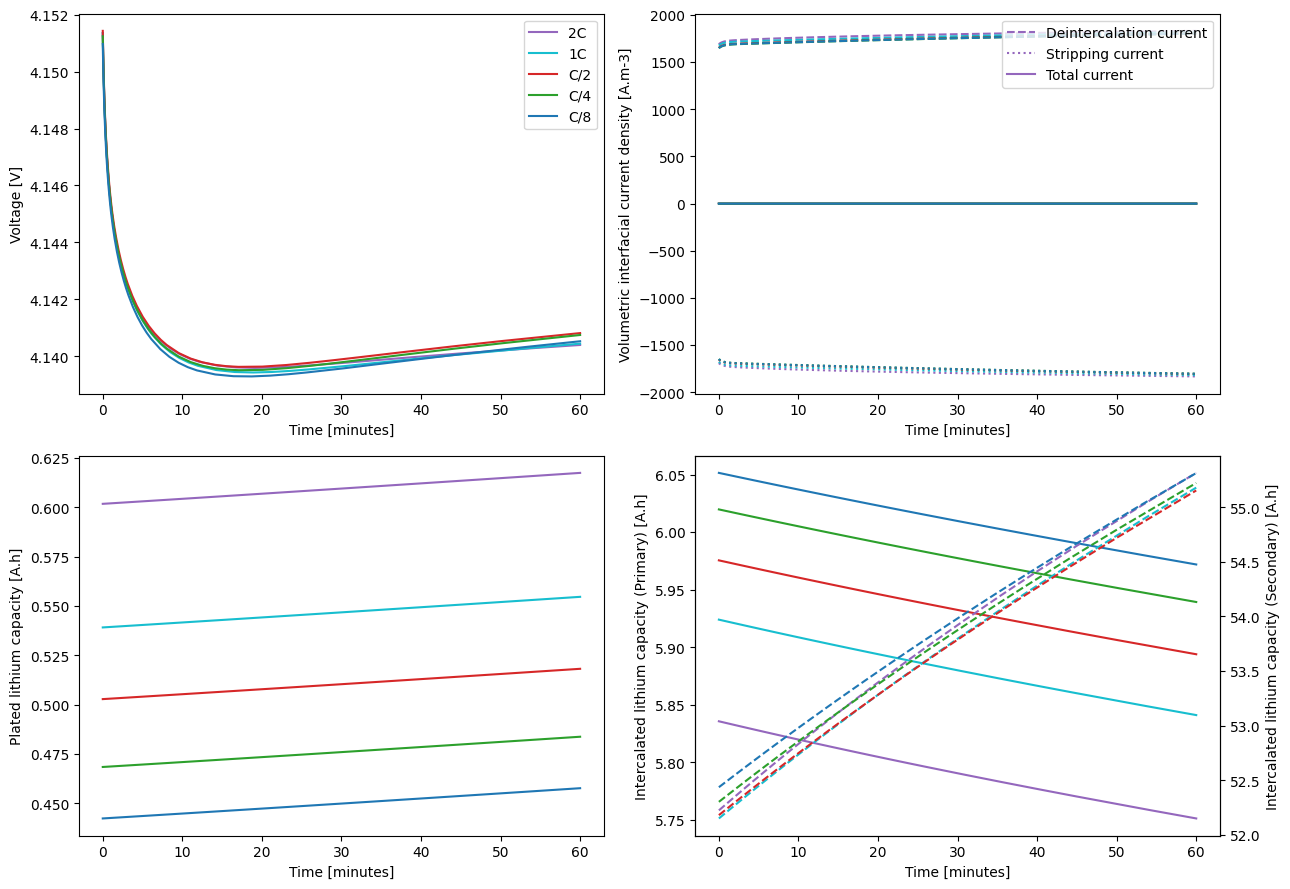

In [11]:
plot(sims_irreversible);

Unlike in the reversible case, there is no steady state and the capacity degrades quickly. The lithium inventory decreases by around 40 mAh in just an hour, which is unrealistic. The low temperature fast charge simulations are run one more time, with the partially reversible plating model.

In [12]:
sims_partially_reversible = define_and_solve_sims(
    models["partially reversible"], experiments, parameter_values
)

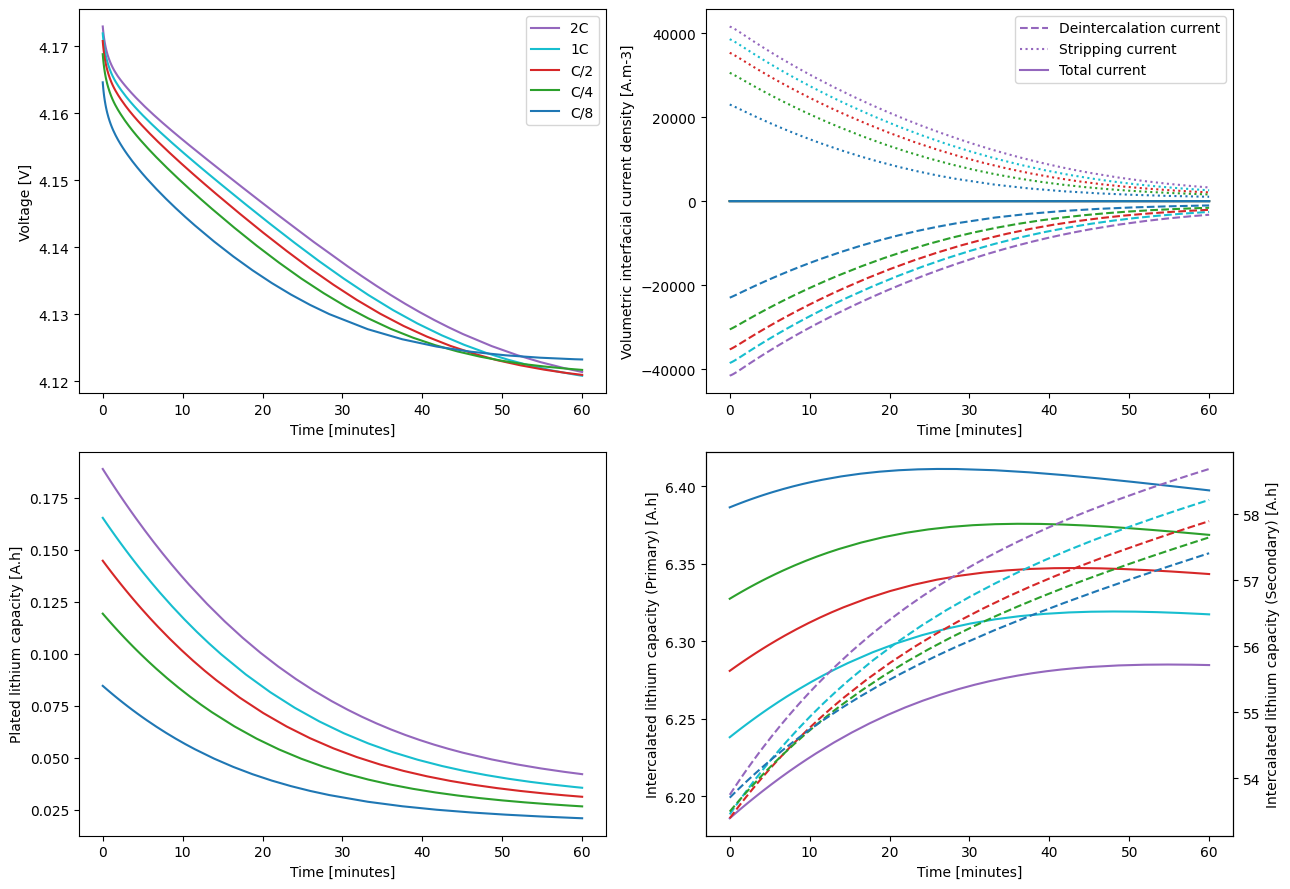

In [13]:
plot(sims_partially_reversible);

The partially reversible plating model has features of both the reversible and irreversible models, which is reflected in the results. The plated lithium capacity decreases with time as lithium is reversibly stripped, but the final plated lithium capacity now depends on charge rate, indicating that some lithium was irreversibly plated during charge.

# References

In [14]:
pybamm.print_citations()

[1] Weilong Ai, Niall Kirkaldy, Yang Jiang, Gregory Offer, Huizhi Wang, and Billy Wu. A composite electrode model for lithium-ion batteries with silicon/graphite negative electrodes. Journal of Power Sources, 527:231142, 2022. URL: https://www.sciencedirect.com/science/article/pii/S0378775322001604, doi:https://doi.org/10.1016/j.jpowsour.2022.231142.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[4] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for